In [55]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
from sklego.linear_model import LowessRegression
import statsmodels.api as sm
from scipy.stats import ttest_ind, skewtest, boxcox
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

### Reading in from external source

In [56]:
table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [57]:
table

,miRNA,Healthy control 1,Healthy control 2,Healthy control 3,Healthy control 4,Healthy control 5,Healthy control 6,Healthy control 7,Healthy control 8,Healthy control 9,...,OD 874,OD 875,OD 876,OD 877,OD 878,OD 879,OD 880,OD 881,OD 882,OD 883
0,hsa-let-7a-3p,5.988790,7.380677,7.672810,6.613076,11.527153,6.802500,5.880256,11.543763,7.154083,...,8.581974,6.405327,9.592039,8.458054,5.231669,9.144063,5.153392,11.459711,20.250156,15.120563
1,hsa-let-7a-5p,2439.692620,20989.575296,31645.820205,39785.067842,31230.353897,38051.171659,958.540489,26414.154148,16586.484823,...,31887.613521,10253.447955,68895.120418,26718.589860,124.858642,63857.761619,856.267323,27600.463068,19488.570664,22283.226524
2,hsa-let-7b-3p,11.780320,15.448649,13.338528,13.885756,19.288142,15.084712,7.185237,16.824500,16.196026,...,21.361416,12.543551,20.264019,14.556385,6.220702,24.859740,7.389210,18.877957,37.245982,22.464665
3,hsa-let-7b-5p,1040.209620,18504.673331,7955.195696,24977.608432,39978.077062,37595.019787,1359.028489,4014.889159,16931.607811,...,4849.241869,1257.587019,10516.197060,10810.224198,479.614342,8749.304276,2202.739323,4600.033750,5339.333966,4008.972424
4,hsa-let-7c-3p,NaN,6.671031,6.848874,5.930795,10.633752,6.246456,5.475492,9.762535,7.198736,...,9.122395,6.682408,10.109299,7.948756,5.192131,8.088978,4.853054,10.748838,19.576433,13.555511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2544,hsa-miR-98-5p,20.964430,84.032030,159.892600,208.987800,125.215600,188.473300,7.963369,135.097300,70.247470,...,155.673200,30.870220,315.734100,165.893100,5.210187,494.706700,6.954913,138.359400,129.100000,97.391580
2545,hsa-miR-99a-3p,5.403362,5.327982,6.421957,5.693892,8.883525,5.658731,5.238846,9.544847,5.510658,...,7.606117,6.243903,9.437917,8.580856,4.516762,7.153301,4.612040,10.001480,17.708110,13.154730
2546,hsa-miR-99a-5p,13.697740,213.873700,184.569600,65.718150,140.656100,316.963400,8.551879,229.411500,83.380180,...,176.617300,13.073290,126.437400,84.271230,6.452502,176.668100,6.973993,64.588090,124.573200,180.569200
2547,hsa-miR-99b-3p,5.110449,5.773773,6.529618,6.206826,8.768461,6.298098,5.377624,11.095780,6.618033,...,8.079693,6.130816,8.947658,7.733689,5.346861,7.124403,4.610744,9.381164,17.945740,12.749490


### Get controls

In [58]:
sick = np.array(["LCa" in t for t in list(table)[1:]])
controls = 1 - sick

In [59]:
sum(sick)

606

### Drop NAN

In [60]:
table = table.dropna(0)

C:\Users\OLEFRE~1\AppData\Local\Temp/ipykernel_6412/338023607.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(0)


### T-test

In [61]:
X = table.iloc[:, 1:].transpose()

In [62]:
X

,0,1,2,3,5,6,7,8,9,10,...,2536,2537,2538,2541,2542,2544,2545,2546,2547,2548
Healthy control 1,5.988790,2439.692620,11.780320,1040.209620,194.282820,7.189860,766.731620,5.351587,8.520220,12.028410,...,4.573345,5.137256,5.491173,4.746277,60.57162,20.964430,5.403362,13.697740,5.110449,11.077200
Healthy control 2,7.380677,20989.575296,15.448649,18504.673331,3965.491812,14.408822,5312.466200,6.295542,21.514407,13.892107,...,5.204015,5.192455,5.732409,5.220955,191.81740,84.032030,5.327982,213.873700,5.773773,111.663100
Healthy control 3,7.672810,31645.820205,13.338528,7955.195696,2217.527520,20.839338,7063.847958,6.827632,25.900714,13.863076,...,6.479215,6.616299,6.557615,5.990099,417.67460,159.892600,6.421957,184.569600,6.529618,197.377500
Healthy control 4,6.613076,39785.067842,13.885756,24977.608432,5927.803928,8.536264,11272.834600,6.348113,28.759241,11.372788,...,5.746677,5.548189,6.290292,5.307264,1573.82700,208.987800,5.693892,65.718150,6.206826,78.274060
Healthy control 5,11.527153,31230.353897,19.288142,39978.077062,9297.550922,17.881494,8031.057737,10.243077,28.621188,17.654802,...,9.177522,9.468003,9.567642,8.611114,452.85390,125.215600,8.883525,140.656100,8.768461,103.701900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OD 879,9.144063,63857.761619,24.859740,8749.304276,2909.559981,28.578137,20097.402512,7.490324,48.978989,21.122499,...,7.140392,6.615213,8.695841,6.951983,2131.15500,494.706700,7.153301,176.668100,7.124403,136.889100
OD 880,5.153392,856.267323,7.389210,2202.739323,250.299623,5.376270,269.119423,4.968522,5.996783,7.609608,...,4.310842,4.612252,4.396836,4.096209,12.14961,6.954913,4.612040,6.973993,4.610744,7.319033
OD 881,11.459711,27600.463068,18.877957,4600.033750,894.023748,19.264314,7342.882355,9.876033,20.532105,16.780401,...,9.455028,9.821029,9.606293,9.087831,1274.89100,138.359400,10.001480,64.588090,9.381164,67.766800
OD 882,20.250156,19488.570664,37.245982,5339.333966,1166.722235,26.898383,4405.036611,17.743496,44.263706,35.855775,...,18.200280,19.668460,19.277460,16.587790,938.91320,129.100000,17.708110,124.573200,17.945740,162.596200


In [63]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [64]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [65]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [66]:
table.iloc[lowest, 0], pvalues

(343      hsa-miR-197-3p
 808     hsa-miR-374c-5p
 806     hsa-miR-374b-5p
 1788        hsa-miR-575
 1977     hsa-miR-660-5p
 Name: miRNA, dtype: object,
 array([1.00274365e-41, 2.17979603e-39, 2.24938929e-39, 2.43941446e-35,
        2.72115728e-33]))

### F-test

In [67]:
t3 = table.iloc[:, 1:].transpose()

In [68]:
f, p = f_classif(t3, sick)

### ANOVA

In [69]:
t3

,0,1,2,3,5,6,7,8,9,10,...,2536,2537,2538,2541,2542,2544,2545,2546,2547,2548
Healthy control 1,5.988790,2439.692620,11.780320,1040.209620,194.282820,7.189860,766.731620,5.351587,8.520220,12.028410,...,4.573345,5.137256,5.491173,4.746277,60.57162,20.964430,5.403362,13.697740,5.110449,11.077200
Healthy control 2,7.380677,20989.575296,15.448649,18504.673331,3965.491812,14.408822,5312.466200,6.295542,21.514407,13.892107,...,5.204015,5.192455,5.732409,5.220955,191.81740,84.032030,5.327982,213.873700,5.773773,111.663100
Healthy control 3,7.672810,31645.820205,13.338528,7955.195696,2217.527520,20.839338,7063.847958,6.827632,25.900714,13.863076,...,6.479215,6.616299,6.557615,5.990099,417.67460,159.892600,6.421957,184.569600,6.529618,197.377500
Healthy control 4,6.613076,39785.067842,13.885756,24977.608432,5927.803928,8.536264,11272.834600,6.348113,28.759241,11.372788,...,5.746677,5.548189,6.290292,5.307264,1573.82700,208.987800,5.693892,65.718150,6.206826,78.274060
Healthy control 5,11.527153,31230.353897,19.288142,39978.077062,9297.550922,17.881494,8031.057737,10.243077,28.621188,17.654802,...,9.177522,9.468003,9.567642,8.611114,452.85390,125.215600,8.883525,140.656100,8.768461,103.701900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OD 879,9.144063,63857.761619,24.859740,8749.304276,2909.559981,28.578137,20097.402512,7.490324,48.978989,21.122499,...,7.140392,6.615213,8.695841,6.951983,2131.15500,494.706700,7.153301,176.668100,7.124403,136.889100
OD 880,5.153392,856.267323,7.389210,2202.739323,250.299623,5.376270,269.119423,4.968522,5.996783,7.609608,...,4.310842,4.612252,4.396836,4.096209,12.14961,6.954913,4.612040,6.973993,4.610744,7.319033
OD 881,11.459711,27600.463068,18.877957,4600.033750,894.023748,19.264314,7342.882355,9.876033,20.532105,16.780401,...,9.455028,9.821029,9.606293,9.087831,1274.89100,138.359400,10.001480,64.588090,9.381164,67.766800
OD 882,20.250156,19488.570664,37.245982,5339.333966,1166.722235,26.898383,4405.036611,17.743496,44.263706,35.855775,...,18.200280,19.668460,19.277460,16.587790,938.91320,129.100000,17.708110,124.573200,17.945740,162.596200


In [70]:
X = np.array(sick).reshape(-1, 1)

In [71]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [72]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.003680189431917301

### Mean-variance-plot

In [73]:
mirnas = table.iloc[:, 0]
table = table.iloc[:, 1:]

In [74]:
table = table.transpose()

In [75]:
np.mean(table)

0           9.081349
1       22968.943128
2          18.962880
3       14366.212882
5        3288.513087
            ...     
2544      123.431074
2545        7.839207
2546       80.060869
2547        8.341195
2548       70.713978
Length: 1183, dtype: float64

In [76]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [77]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

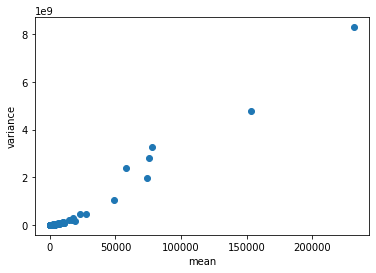

In [78]:
mean_variance_plot(table)

In [79]:
log_table = np.log2(table)

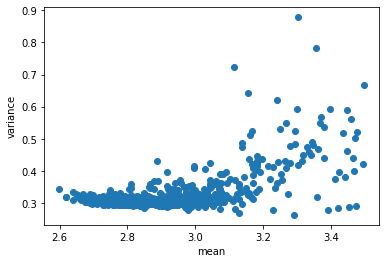

In [80]:
mean_variance_plot(log_table.loc[:, np.mean(log_table) < 3.5])

In [81]:
mask = np.mean(log_table) > 3.2
mirnas = mirnas[mask]
log_table = log_table.loc[:, mask]

### Loess regression

In [82]:
lowess = LowessRegression(sigma=1, span=0.1)

In [83]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [84]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

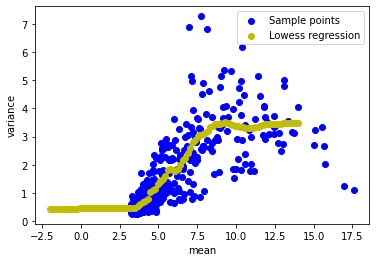

In [85]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

### Lowess normalization

In [86]:
adj_var = lowess.predict(means.to_numpy().reshape(-1, 1))

In [87]:
log_table /= np.sqrt(adj_var)

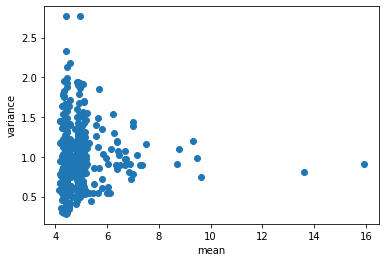

In [88]:
mean_variance_plot(log_table)

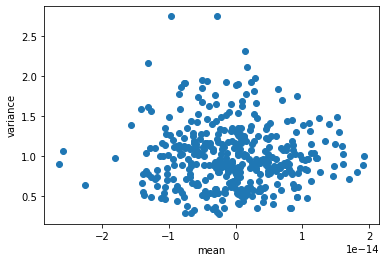

In [89]:
norm_log_table = log_table - np.mean(log_table)
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))
mean_variance_plot(norm_log_table)

In [90]:
norm_log_table = log_table - np.mean(log_table)

In [91]:
norm_log_table /= np.mean(np.std(norm_log_table))

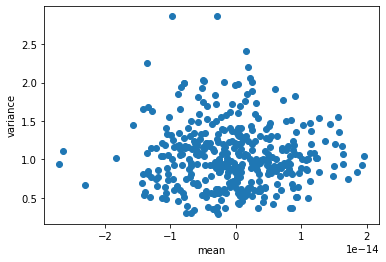

In [92]:
mean_variance_plot(norm_log_table)

### PCA

In [93]:
pca = decomposition.PCA(n_components=10)

In [94]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [95]:
pca.explained_variance_ratio_

array([0.57273515, 0.11751098, 0.05833682, 0.0468864 , 0.02118602,
       0.01723204, 0.01591434, 0.01322661, 0.01149101, 0.00856726])

In [96]:
components = pca.transform(norm_log_table)

In [97]:
components

array([[ 2.63772559e+01, -2.92728896e+00,  2.52978813e+00, ...,
        -3.49952988e-01, -9.57459237e-01, -6.98941840e-01],
       [-8.55974369e+00, -5.55509861e+00, -4.20377676e+00, ...,
        -3.52479681e+00, -4.69851559e+00,  1.94378919e+00],
       [-1.02960089e+01, -8.53601798e+00,  1.97291056e+00, ...,
         3.72319901e-01,  1.82482319e-01,  4.01693745e+00],
       ...,
       [-8.63353945e+00, -3.93821137e+00,  5.38228452e+00, ...,
        -1.96618321e-01,  4.50024295e+00,  8.87138078e-01],
       [-2.18906065e+01,  1.10108977e+01,  8.76702239e+00, ...,
        -6.57802614e-01,  7.48603447e-01,  1.17153861e-03],
       [-1.37669589e+01, -2.17104155e+00,  9.29528872e+00, ...,
        -6.07610079e-01, -1.57476107e+00,  2.46761866e+00]])

In [98]:
sum(controls)

2440

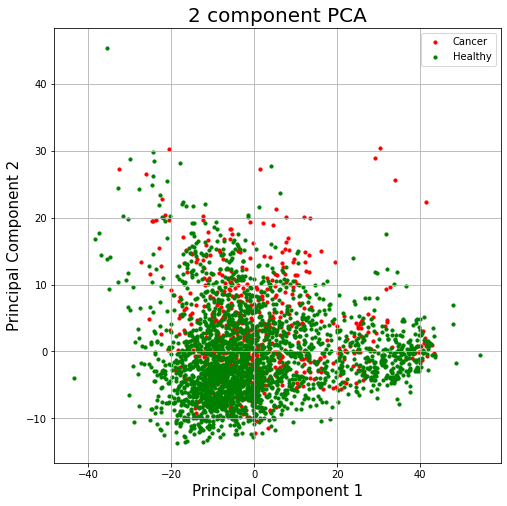

In [99]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [100]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

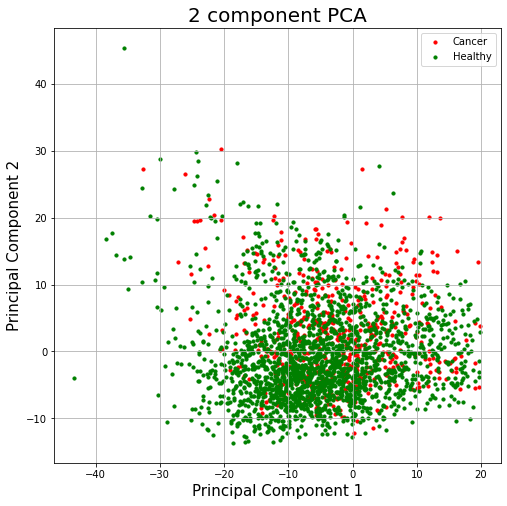

In [101]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### XGBoost

In [102]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [103]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[15:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

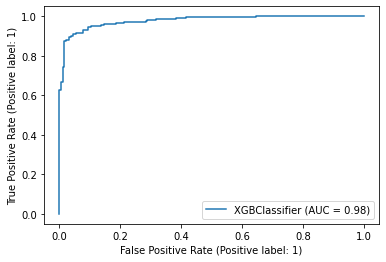

In [104]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [105]:
from Scripts import converters

In [106]:
sequences = converters.canonical_to_seq(mirnas)

In [107]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

,UGAGGUAGUAGGUUGUAUAGUU,CUAUACAACCUACUGCCUUCCC,UGAGGUAGUAGGUUGUGUGGUU,UGAGGUAGUAGGUUGUAUGGUU,CUAUACGACCUGCUGCCUUUCU,AGAGGUAGUAGGUUGCAUAGUU,UGAGGUAGGAGGUUGUAUAGUU,CUAUACAAUCUAUUGCCUUCCC,UGAGGUAGUAGAUUGUAUAGUU,UGAGGUAGUAGUUUGUACAGUU,...,CAAAGUGCUGUUCGUGCAGGUAG,UGUGCGCAGGGAGACCUCUCCC,UGGGGAGCUGAGGCUCUGGGGGUG,AAGGCAGGGCCCCCGCUCCCC,UCUUCUCUGUUUUGGCCAUGUG,UUUGGCACUAGCACAUUUUUGCU,UGAGGUAGUAAGUUGUAUUGUU,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
Healthy control 1,-1.346184,-0.668957,-1.649790,-1.799416,-1.260096,-1.242500,-1.412364,-0.532290,-1.251303,-1.166655,...,-1.126151,-0.663360,-0.923872,-1.055009,-1.688865,-1.110719,-1.332165,-1.431752,-1.647219,False
Healthy control 2,0.341706,-0.195561,0.616884,0.638735,0.052322,0.289248,-0.093661,-0.275762,0.348440,0.119682,...,0.287335,-0.077039,-0.014514,0.228393,1.060671,-0.150676,0.188154,1.527163,0.868147,False
Healthy control 3,0.663716,-0.452025,-0.047856,0.168871,0.748964,0.514723,0.170495,-0.279488,0.712059,0.504659,...,0.204486,-0.669859,0.022907,0.127937,1.495416,0.497415,0.892597,1.368503,1.488260,False
Healthy control 4,0.843226,-0.381814,0.853076,0.963726,-0.936032,0.884594,0.319535,-0.632102,1.081566,1.257505,...,1.050979,-0.466605,0.702837,-0.156118,0.222719,1.602246,1.185820,0.256656,0.481392,False
Healthy control 5,0.653351,0.192055,1.223441,1.327579,0.459970,0.616271,0.312685,0.151080,0.624390,0.284600,...,0.608666,0.399076,0.935711,0.244783,0.987530,0.564765,0.624898,1.075957,0.787626,False


In [108]:
norm_log_table.to_csv("../TransformedData/Fehlman2020.csv", index=False)